#Predicting Bitcoin Price

##Forecasting

Use the exported data from 'Data Collection and Exploration' notebook to forecast the direction of the price of bitcoin.

###Imports

In [418]:
import pandas as pd
from pandas.io.data import DataReader

import numpy as np
from datetime import datetime

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.cross_validation import train_test_split
import statsmodels.formula.api as smf
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


###Creating Lagged Series

Create a pandas DataFrame that contains the lagged percentage returns for a prior number of days (based on the approach described in [Forecasting Financial Time Series](https://www.quantstart.com/articles/Forecasting-Financial-Time-Series-Part-1)).

Define a method to read in the collated bitcoin dataset and select the most recent 2 years:

In [419]:
def get_data(filename, index):
    data = pd.read_csv(filename, index_col=index)
    data = data[(data.date >= '2012-01-01') & (data.date <= '2015-12-31')]

    return data

Define methods create a series of lagged data and percentage returns corresponding to how much the price went up or down compared to the present daily price:

In [510]:
def create_lagged_df(data, lags):
    datalag = pd.DataFrame(index=data.index)
    datalag["price_usd"] = data["price_usd"]
    datalag["percent_cost"] = data["percent_cost"]
    datalag["exchange_vol_usd"] = data["exchange_vol_usd"] 
    datalag["market_cap"] = data["market_cap"]
    datalag["deficit"] = data["deficit"]
    datalag["miners_revenue"] = data["miners_revenue"]
    datalag["transaction_fees_usd"] = data["transaction_fees_usd"]
    
    # Create the shifted lag series of prior trading period price values
    for i in xrange(0,lags):
        datalag["lag%s" % str(i+1)] = data["price_usd"].shift(i+1)
   
    return datalag


def create_returns_df(datalag):
    returns = pd.DataFrame(index=datalag.index)
    returns["price_usd"] = datalag["price_usd"].pct_change()*100.0
    
    return returns

In [511]:
def create_lagged_series(lags=30):
    data = get_data('bitcoin_price.csv', 'trading_day')
    
    datalag = create_lagged_df(data, lags)

    returns = create_returns_df(datalag)

    # If any of the values of percentage returns equal zero, set them to
    # a small number (stops issues with QDA model in scikit-learn)
    for i,x in enumerate(returns["price_usd"]):
        if (abs(x) < 0.0001):
            returns["price_usd"][i] = 0.0001

    # Create the lagged percentage returns columns
    for i in xrange(0,lags):
        returns["lag%s" % str(i+1)] = datalag["lag%s" % str(i+1)].pct_change()*100.0
        
    # Create the lagged percentage returns columns
    for i in xrange(0,lags):
        returns["lag%s" % str(i+1)] = datalag["lag%s" % str(i+1)].pct_change()*100.0
        
    # Create the moving average columns commonly used to smooth out short-term 
    # fluctuations and highlight longer-term trends in financial time-series analysis
    returns['ma_3'] = pd.rolling_mean(returns['price_usd'].shift(-1), 3)
    returns['ma_7'] = pd.rolling_mean(returns['price_usd'].shift(-1), 7)
    returns['ma_14'] = pd.rolling_mean(returns['price_usd'].shift(-1), 7)
    
    # Create the moving standard deviation
    returns['msd_3'] = pd.rolling_std(returns['price_usd'].shift(-1), 3)
    returns['msd_7'] = pd.rolling_std(returns['price_usd'].shift(-1), 7)
    
    returns["percent_cost"] = datalag["percent_cost"]
    returns["exchange_vol_usd"] = np.log10(datalag["exchange_vol_usd"]) 
    returns["market_cap"] = np.log10(datalag["market_cap"])
    returns["deficit"] = datalag["deficit"]
    returns["miners_revenue"] = datalag["miners_revenue"]
    returns["transaction_fees_usd"] = datalag["transaction_fees_usd"]
    
    
    # Create the "Direction" column (+1 or -1) indicating an up/down day
    returns["direction"] = np.sign(returns["price_usd"])

    return returns

Define a method to fit the model on the training set, predict on the test data whether the price of bitcoin will increase or decrease from the prior day's price, then calculate the hit rate:

In [512]:
def fit_model(name, model, X_train, y_train, X_test, pred):
    # Fit and predict the model on the training, and then test, data
    fitted_model = model.fit(X_train, y_train)
    pred[name] = model.predict(X_test)

    # Create a series with 1 being correct direction, 0 being wrong
    # and then calculate the hit rate based on the actual direction
    pred["%s_Correct" % name] = (1.0 + pred[name] * pred["Actual"])/2.0
    hit_rate = np.mean(pred["%s_Correct" % name])
    print "%s: %.3f" % (name, hit_rate)
    
    # Same as score
    #print 'Score: ', model.score(X_test, pred['Actual'])

    print fitted_model, "\n"

Create the lagged series and exclude NAs:

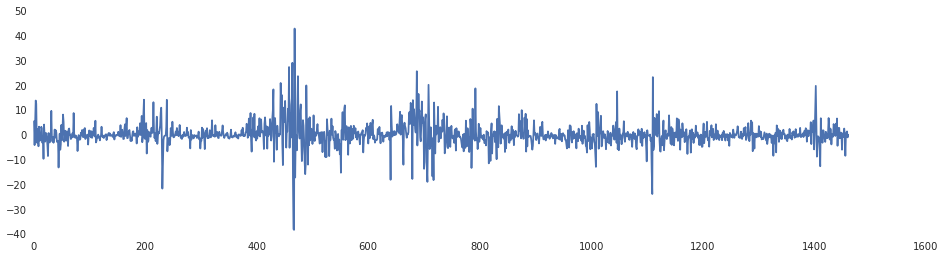

In [513]:
btc = create_lagged_series(lags=14)
plt.figure(figsize=(16,4))
plt.plot(btc['price_usd'])
btc = btc.dropna()

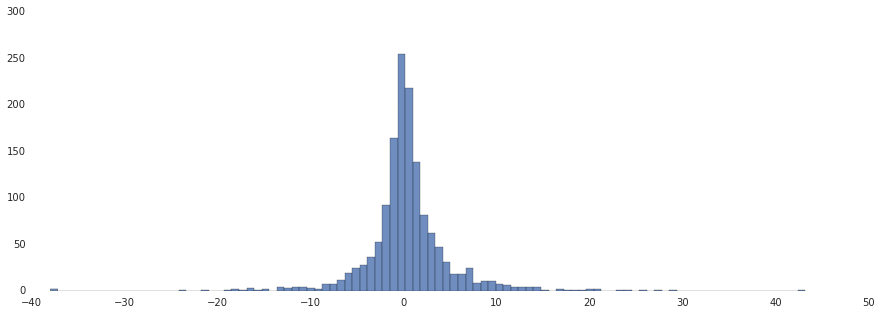

In [514]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

numBins = 100
ax.hist(btc['price_usd'],numBins,alpha=0.8)
plt.show()

In [515]:
print btc.corr()['direction'].sort_values()

percent_cost           -0.072996
lag2                   -0.046825
miners_revenue         -0.028535
lag12                  -0.013902
lag4                   -0.009251
market_cap             -0.005580
lag7                   -0.002665
lag3                   -0.002087
lag9                    0.002615
msd_7                   0.007563
msd_3                   0.009322
lag8                    0.013525
lag5                    0.013926
lag1                    0.016055
lag13                   0.020213
deficit                 0.029107
exchange_vol_usd        0.029736
lag6                    0.034571
transaction_fees_usd    0.041175
lag14                   0.042847
lag11                   0.049097
lag10                   0.074903
ma_7                    0.230498
ma_14                   0.230498
ma_3                    0.385493
price_usd               0.574435
direction               1.000000
Name: direction, dtype: float64


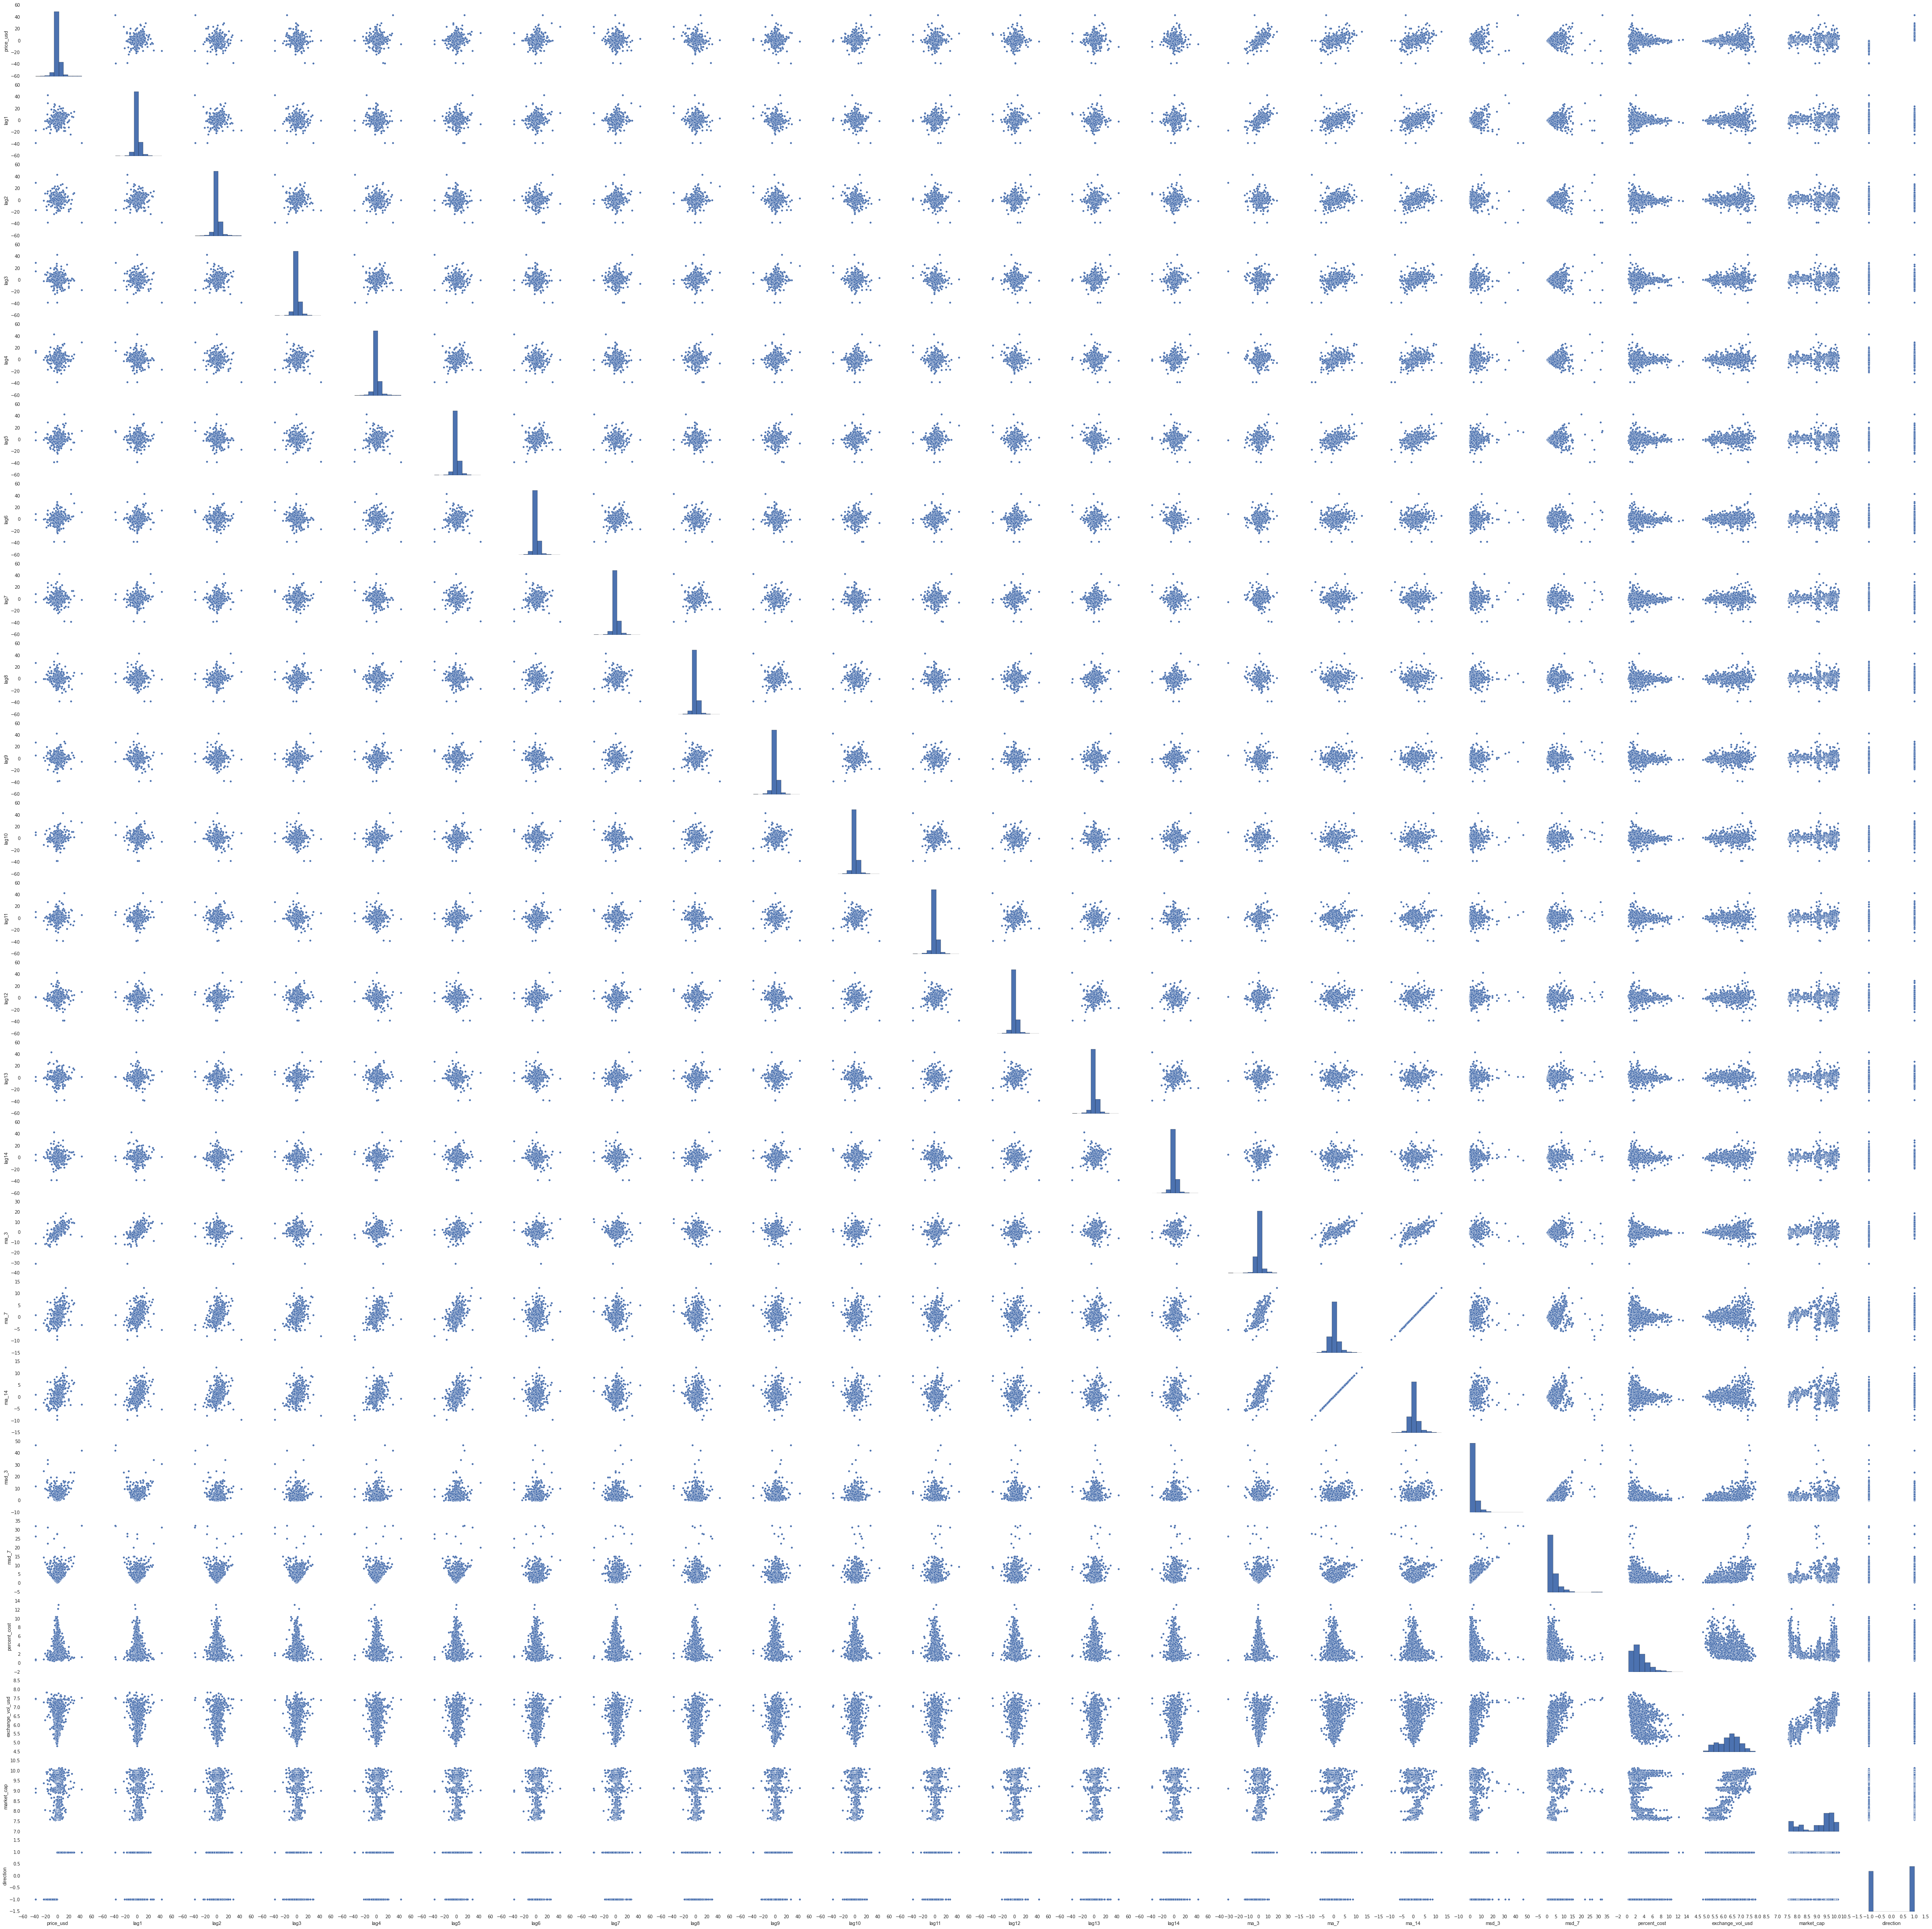

In [493]:
g = sns.pairplot(btc)

In [494]:
def calc_hit_rates(predictors):
    X = btc[predictors]
    y = btc["direction"]
    start_test = '2015-12-01'

    # Create training and test sets
    X_train = X[X.index < start_test]
    X_test = X[X.index >= start_test]
    y_train = y[y.index < start_test]
    y_test = y[y.index >= start_test]

    # Create the prediction DataFrame:
    pred = pd.DataFrame(index=y_test.index)
    pred["Actual"] = y_test

    # Create and fit three basic models:
    print "Hit Rates using the predictors", predictors
    models = [("LR", LogisticRegression()), ("LDA", LDA()), ("QDA", QDA())]
    for m in models:
        fit_model(m[0], m[1], X_train, y_train, X_test, pred)

    #print pred.head()

In [508]:
predictors = ["ma_3"]
calc_hit_rates(predictors)


Hit Rates using the predictors ['ma_3']
LR: 0.633
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

LDA: 0.633
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001) 

QDA: 0.633
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001) 



In [496]:
predictors = ["ma_3", "ma_7", "ma_14"]
calc_hit_rates(predictors)

Hit Rates using the predictors ['ma_3', 'ma_7', 'ma_14']
LR: 0.600
LDA: 0.600
QDA: 0.467


In [497]:
predictors = ["lag10", "lag11", "lag14", "lag6", "lag13", "lag1"]
calc_hit_rates(predictors)

Hit Rates using the predictors ['lag10', 'lag11', 'lag14', 'lag6', 'lag13', 'lag1']
LR: 0.733
LDA: 0.700
QDA: 0.433


In [498]:
predictors = ["msd_3", "msd_7"]
calc_hit_rates(predictors)

Hit Rates using the predictors ['msd_3', 'msd_7']
LR: 0.667
LDA: 0.667
QDA: 0.667


In [499]:
predictors = ["lag1", "ma_3"]
calc_hit_rates(predictors)

Hit Rates using the predictors ['lag1', 'ma_3']
LR: 0.733
LDA: 0.800
QDA: 0.767


In [509]:
predictors = ["lag1", "ma_3", "exchange_vol_usd"]
calc_hit_rates(predictors)

Hit Rates using the predictors ['lag1', 'ma_3', 'exchange_vol_usd']
LR: 0.800
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

LDA: 0.800
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001) 

QDA: 0.767
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001) 



In [501]:
predictors = ["lag1", "ma_3", "market_cap"]
calc_hit_rates(predictors)

Hit Rates using the predictors ['lag1', 'ma_3', 'market_cap']
LR: 0.767
LDA: 0.800
QDA: 0.767


In [502]:
predictors = ["lag1", "ma_3", "percent_cost"]
calc_hit_rates(predictors)

Hit Rates using the predictors ['lag1', 'ma_3', 'percent_cost']
LR: 0.800
LDA: 0.767
QDA: 0.733


In [523]:
predictors = ["lag1", "ma_3", "deficit", "exchange_vol_usd"]
calc_hit_rates(predictors)

Hit Rates using the predictors ['lag1', 'ma_3', 'deficit', 'exchange_vol_usd']
LR: 0.567
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

LDA: 0.800
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001) 

QDA: 0.733
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001) 

